# Neural Network Modeling Notebook

### Imports:

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Keras Imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras import optimizers
from keras.callbacks import ModelCheckpoint

# Scikit-Learn Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# For setting random seed
from numpy.random import seed
from tensorflow import set_random_seed

# Set random seed to ensure reproducible results
rand_seed = 112
seed(rand_seed)
set_random_seed(rand_seed)

### Load the Data:

In [8]:
has_planets = pd.read_csv('../clean_planet_data/clean_labeled_planets_seed.csv')

In [9]:
c4_kep = pd.read_csv('../clean_planet_data/clean_labeled_c4_kep_seed.csv')

In [10]:
# has_planets = pd.read_csv('https://hkvbeg.bn.files.1drv.com/y4mlNbHDTm5VQseIrjQaNKoo0pBiUMbfjlS6uaPbSjDv9_cC0qSRXiZp2ipI0r3DZrlFckN47lIoaCEfVwlzRqcFEVsyqpLL6donvNRJYNkOrOPhL4HtZu-Fwx-qDizNWcJIrObkW9YhAmdNOE0KXIJRfhPYbsvK1-asHeUx_V_RG_-2h_haqUfXL72eWmPkJQI/clean_labeled_planets_seed.csv?download&psid=1')

In [11]:
# c4_kep = pd.read_csv('https://hkveeg.bn.files.1drv.com/y4mJE7IcMFZmmx8Ta9GXPVy63FizLYjFw3guxJF04Zbz5zt_H809sEQPiQqvPYwlpAyrm7XJrmUCN2mbEQLYsTBLiw1-3kF6tqRczhJygcMHaE04FdeCKy7D-o4wwO5SLdwlwRHRLV_aUkGxBPYyF6VYRo_0kJNqrs8BYziTAfhaoSYLlrF54yTECVwCciPs8XX/clean_labeled_c4_kep_seed.csv?download&psid=1')

<hr>

# Preprocessing Data:
### Mix confirmed planets into data so the model can learn what they are like.

In [12]:
# cut out the extra data to compare across the same timeline (~3200 points)
join_planets = has_planets.iloc[:,:3199]
# oversample = join_planets.sample(n=join_planets.shape[0], replace=True, random_state=rand_seed)
# join_planets = pd.concat([join_planets, oversample])

In [13]:
join_planets.shape

(1156, 3199)

In [14]:
# Randomly select stars to train on, then set aside the rest as'unseen' data
to_train_on = c4_kep.sample(2705, random_state=rand_seed).iloc[:,:3199] # 2705

c4_holdout = c4_kep.iloc[:,:3199]

i = 0

for _ in c4_holdout['star_name']:
    if _ in list(to_train_on['star_name']):
        c4_holdout.drop(index=i, inplace=True)
#         print('akbsfkahsfohjsaodifj')
    i += 1

c4_holdout.reset_index(drop=True, inplace=True)

In [15]:
c4_holdout.shape

(5008, 3199)

In [16]:
# Put training data together into master_df
master_df = pd.concat([join_planets, to_train_on], axis = 0)

In [17]:
# Calculate Baseline Accuracy
val_count = master_df['label'].value_counts()
base_acc = val_count[1] / val_count.sum()

print('Baseline Acc: ', base_acc)
print(val_count)

Baseline Acc:  0.3045843045843046
0    2685
1    1176
Name: label, dtype: int64


### Scaling
Normalize the light curves so that stars of different brightnesses can be compared.

In [18]:
# Make X and y
X = master_df.iloc[:, 2:]
y = master_df['label']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [19]:
# instantiate StandardScaler as ss
ss = StandardScaler()

In [20]:
# transpose to scale each lightcurve row (rather than columns)
X_train = X_train.T
X_test = X_test.T

# Scaling
scaled_df = ss.fit_transform(X_train)
X_train = pd.DataFrame(scaled_df, columns=X_train.columns)

test_scaled_df = ss.fit_transform(X_test)
X_test = pd.DataFrame(test_scaled_df, columns=X_test.columns)

# Transpose back to normal
X_train = X_train.T
X_test = X_test.T

In [21]:
# make into an array and then change the dimensions
X_array = np.array(X_train)
X_array = np.expand_dims(X_array, axis = 2)

# do this for the test set too
X_test_array = np.array(X_test)
X_test_array = np.expand_dims(X_test_array, axis = 2)

### Prepare Unseen Dataset:

In [22]:
# slice out the light curve
unseen_data = c4_holdout.iloc[:,2:3199]

# Scale
unseen_data = unseen_data.T # transpose to scale each lightcurve row (rather than columns)

scaled_unseen = ss.fit_transform(unseen_data)
unseen_data = pd.DataFrame(scaled_unseen, columns=unseen_data.columns)

unseen_data = unseen_data.T # Transpose back to normal

# Change the dimensions so it can be put through the neural network
array_unseen = np.array(unseen_data)
array_unseen = np.expand_dims(array_unseen, axis = 2)

<hr>

# Define Functions for Evaluating the Results Later:

In [84]:
# This will be used later to show how the model learned over the epochs

def learning_plots(title, metric, val_metric, y_label, c_train='#1f77b4', c_test='orange'):

    # Instantiate plot
#     plt.figure()

    # Plot metric of interest
    plt.plot(result.history[metric], color = c_train)
    plt.plot(result.history[val_metric], color = c_test)

    # Set title
    plt.title(title)

    # Set axis labels
    plt.ylabel(y_label)
    plt.xlabel('Epoch (# of iterations)')

    # Add a legend
    plt.legend(['Train', 'Test'], loc='best')

    # Plot girdlines:
    plt.grid()
    
#     return ax

    plt.show();

This will be used for showing the evaluation metrics.

In [100]:
def analyze_results(predictions, y_test): #, all_results):


    # Calculate values for the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    total = (tp + tn + fp + fn)

    
    index_labels = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision']
    scores = pd.DataFrame(index = index_labels, columns=['Results'])
    
    # Calculate results
    decimals = 3

    scores.loc['Accuracy'] = round((tp+tn) / (total), decimals)
    scores.loc['Sensitivity'] = round(tp / (tp+fn), decimals)
    scores.loc['Specificity'] = round(tn / (tn+fp), decimals)
    scores.loc['Precision'] = round(tp / (tp+fp), decimals)

    # Display the rounded results
    display(scores)
    
    # Turn confusion matrix values into a dataframe
    confusion = pd.DataFrame(index= ['Pred. Positive','Pred. Negative', 'Total'])

    confusion['Act. Positive'] = tp, fn, (tp + fn)
    confusion['Act. Negative'] = fp, tn, (fp + tn)

    confusion['Total'] = (tp + fp), (fn + tn), total

    display(confusion)
    
    print((tp + fp), 'predicted to have planets', '\n',
    tp, 'true positive planet stars predicted', '\n',
    round(tp/(tp+fn)*100, 3), '% of all true planets') 
    
    # Rate of planets in predictions
    tp_rate = (tp / (tp + fp))
    # Rate of planets in all unseen test set
    all_rate = (tp + fn) / total
    # Performance compared to chance
    print(round(tp_rate / all_rate, 3), 'times better than chance')
        
    return scores, confusion

This will be used to plot the auc-roc curve when evaluating the predictions.

In [88]:
def plot_roc(y_test, y_hat_proba):
# Plot ROC-AUC curve

    # Generate False positive rate and True positive rate
    fpr, tpr, _ = roc_curve(y_test, y_hat_proba)
    roc_auc = auc(fpr, tpr)

    # Plot settings
    plt.figure(figsize=(6, 4))
    line_width = 4
    
    # Title and labels
    plt.title('ROC Curve', fontsize=25, position = (0.2,1))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    string = 'Area Under Curve: ' + str(round(roc_auc, 3))
    plt.text(x=1, y=0.05, s=string, horizontalalignment='right')
    
    # Gridlines
    plt.grid(True)
    
    plt.plot(fpr, tpr, lw = line_width)
    plt.plot([0, 1], [0,1], lw = line_width, linestyle = '--')

<hr>

# Neural Network Modeling:
### Architecture:

In [35]:
# Compute class_weights to pass into the model
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [90]:
# Define model architecture
model = Sequential()

# Convolutional and layer.
model.add(Conv1D(filters = 15, # tuned for 15
                 kernel_size = (20),  # filter size, tuned for 20
                 activation = 'relu',
                 input_shape = (3197, 1))) # dimensions of training data

# model.add(MaxPooling1D(pool_size = (1)))

# Convolutional layer
model.add(Conv1D(filters = 20, 
                 kernel_size = 30, # best so far 30
                 activation = 'relu'))

# model.add(MaxPooling1D(pool_size = (1)))

# Convolutional layer
model.add(Conv1D(filters = 10, # best so far 10
                 kernel_size = 60, # best so far 60
                 activation = 'relu'))

# Convolutional layer
model.add(Conv1D(filters = 20, 
                 kernel_size = 20,
                 activation = 'relu'))

# Pooling:
model.add(MaxPooling1D(pool_size = (3))) # best so far 3
model.add(Dropout(0.2)) # best so far .2




# Convolutional layer
model.add(Conv1D(filters = 20, 
                 kernel_size = 10,
                 activation = 'relu'))

# Convolutional layer
model.add(Conv1D(filters = 7, # tuned for 7, new-
                 kernel_size = 10, # tuned for 20, new-
                 activation = 'relu'))

# Pooling layer.
model.add(MaxPooling1D(pool_size = (5))) # best so far 5
model.add(Dropout(0.25)) # regularization tuned for .25, confirmed 2nd round







# Convolutional layer
model.add(Conv1D(filters = 10, # tuned to 10, confirmed 2nd round
                 kernel_size = 30, # tuned to 10, second round ~30
                 activation = 'relu'))

# model.add(Conv1D(filters = 7,
#                  kernel_size = 5, # 5?
#                  activation = 'relu'))

# Pooling layer.
model.add(MaxPooling1D(pool_size = (5))) # tuned to 5, confirmed 2nd round
model.add(Dropout(0.5)) # regularization tuned to .5



# Organize neurons by flattening.
model.add(Flatten())

# Fully connected hidden layers.

# Hidden layer 1
model.add(Dense(2500, activation = 'relu')) # 1st round- 2500, .7 drop
model.add(Dropout(0.6)) # best so far .4

model.add(Dense(1500, activation = 'relu')), # 1st round- 1000, .7 drop, 2nd best so far 1500, .4 drop
model.add(Dropout(0.6)) # best so far .5?

# model.add(Dense(500, activation = 'relu'))



# Output layer
model.add(Dense(1, activation = 'sigmoid'))

# Setting learning rate and decay
learn_rate = 0.001
# # x% reduction in learing_rate by epoch: coef_by_epoch
# coef_reduce = .75
# coef_by_epoch = 30

# Calculate decay
decay = 0 #(learn_rate - (coef_reduce * learn_rate)) / coef_by_epoch

# Changing adam optimization parameters
optimizers.adam(lr = learn_rate, decay = decay)

# Compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

# saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=0, save_best_only=True,) 
#                                monitor='val_acc', mode='max')

### Fit the Network:

In [91]:
# Keep track of the runtime:
start_time = time.time()

# Set the random state
seed(rand_seed)
set_random_seed(rand_seed)

# Fit the model:
result = model.fit(X_array,
                   y_train,
                   batch_size = 64,
                   epochs = 30,
                   verbose = 1,
                   validation_data = (X_test_array, y_test),
                   class_weight = class_weights,
                   callbacks = [checkpointer])

# Print the runtime:
print('Runtime: ', round((time.time() - start_time)/60, 3), ' minutes')

Train on 2895 samples, validate on 966 samples
Epoch 1/30
2895/2895 [==============================] - 182s 63ms/step - loss: 0.6414 - acc: 0.6805 - val_loss: 0.6223 - val_acc: 0.6957
Epoch 2/30
2895/2895 [==============================] - 140s 48ms/step - loss: 0.6000 - acc: 0.6953 - val_loss: 0.5943 - val_acc: 0.6957
Epoch 3/30
2895/2895 [==============================] - 135s 47ms/step - loss: 0.5809 - acc: 0.6953 - val_loss: 0.6202 - val_acc: 0.6957
Epoch 4/30
2895/2895 [==============================] - 159s 55ms/step - loss: 0.5787 - acc: 0.6978 - val_loss: 0.5712 - val_acc: 0.7029
Epoch 5/30
2895/2895 [==============================] - 154s 53ms/step - loss: 0.5774 - acc: 0.6978 - val_loss: 0.5768 - val_acc: 0.7122
Epoch 6/30
2895/2895 [==============================] - 180s 62ms/step - loss: 0.5803 - acc: 0.7026 - val_loss: 0.5736 - val_acc: 0.6967
Epoch 7/30
2895/2895 [==============================] - 162s 56ms/step - loss: 0.5572 - acc: 0.7168 - val_loss: 0.5579 - val_acc: 0

### Network Training Plots:
Training accuracy and loss functions vs. epochs

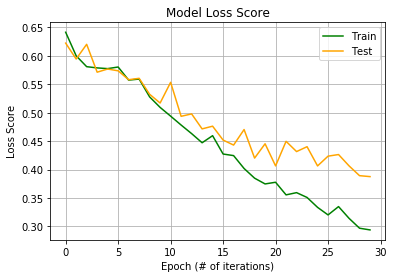

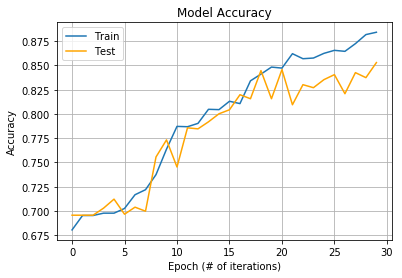

In [92]:
# Plot loss score over epoch
learning_plots(title = 'Model Loss Score', 
                 metric = 'loss', 
                 val_metric = 'val_loss', 
                 y_label = 'Loss Score',
                 c_train = 'green',
                 c_test = 'orange')

# Plot accuracy over epochs
learning_plots(title = 'Model Accuracy', 
                     metric = 'acc', 
                     val_metric = 'val_acc', 
                     y_label = 'Accuracy')

### Testing on Unseen Data:
Now that the model has been fit, lets see if we can use it to detect some planets in data not seen before.

In [93]:
# Load the best weights from the checkpoint
model.load_weights("weights.hdf5")

# Make Predictions
y_unseen = model.predict_classes(array_unseen)
# Predict probabilities
pred_proba = model.predict_proba(array_unseen)

# make df of true labels and index
true_y_unseen = c4_holdout['label']

In [101]:
# Run the analyze_results function
results_df, confusion_df = analyze_results(predictions = y_unseen, 
                                           y_test = true_y_unseen)

,Results
Accuracy,0.923
Sensitivity,0.178
Specificity,0.929
Precision,0.022


,Act. Positive,Act. Negative,Total
Pred. Positive,8,351,359
Pred. Negative,37,4612,4649
Total,45,4963,5008


359 predicted to have planets 
 8 true positive planet stars predicted 
 17.778 % of all true planets
2.48 times better than chance


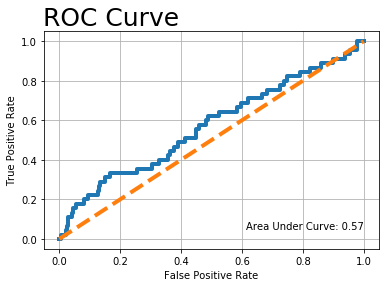

In [95]:
# Plot auc-roc curve
plot_roc(true_y_unseen, pred_proba)

### Done!

<hr>